# This notebook contian code to load yolov3 tiny crowdperson model loaidng and inference


In [3]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
#print("Cuda version: {}".format(tf_build_info.cuda_version_number))
#print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

TensorFlow version: 2.7.0
Eager execution: True
Keras version: 2.7.0
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


In [4]:
from keras.models import load_model, Model
from keras.engine.base_layer import Layer
import tensorflow as tf
class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return (inputs* tf.math.tanh(mysoftplus(inputs)))

    def get_config(self):
        config = super(Mish, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return input_shape
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    

yolo_model = load_model("D:/ModelGraph/Intrusion_Detection/yolov4-crowdperson-detection.h5",custom_objects={"Mish":Mish})

In [14]:
#load model from saved_model instead of h5
from keras.models import load_model, Model
yolo_model = load_model("bialcrowd")
#yolo_model.save('bialcrowd')

In [5]:
from keras import backend as K
import numpy as np
anchors = '12, 16,  19, 36,  40, 28,  36, 75,  76, 55,  72, 146,  142, 110,  192, 243,  459, 401'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1, 2)
class_names = ['head' ,'person']


In [15]:
from PIL import ImageDraw, Image ,ImageFont
import cv2
def letterbox_image(image, size):
    '''Resize image with unchanged aspect ratio using padding'''
    img_width, img_height = image.size
    w, h = size
    scale = min(w / img_width, h / img_height)
    nw = int(img_width * scale)
    nh = int(img_height * scale)
    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))
    return new_image
frame = cv2.imread('images/0004.jpg')
#image  = Image.open('images/0001.jpg')
image = Image.fromarray(frame)
print(image.size)
model_image_size = (416, 416)
boxed_image = letterbox_image(image, model_image_size)
image_data = np.array(boxed_image, dtype='float32')
print(image_data.shape)
image_data /= 255.
image_data = np.expand_dims(image_data, 0)

(960, 720)
(416, 416, 3)


In [7]:
yolo_model.summary() 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 416, 416, 32  128        ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

In [8]:
def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=200,
              score_threshold=.3,
              iou_threshold=.5):
    """Evaluate YOLO model on given input and return filtered boxes."""
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_


In [9]:

def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[...,::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[...,::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs


In [10]:
def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores


In [11]:
def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


In [16]:
import tensorflow as tf
yhat = yolo_model.predict(image_data)
#t = tf.convert_to_tensor(value=t, dtype='float32')
ypredict = [tf.convert_to_tensor(value=a, dtype='float32')  for a in yhat]
out_boxes, out_scores, out_classes  = yolo_eval(ypredict,anchors, len(class_names), (720, 960))
out_boxes= out_boxes.numpy()
out_scores = out_scores.numpy()
out_classes = out_classes.numpy()
image_orig =image_data * 255
image_orig = np.squeeze(image_orig, axis=0).astype('uint8')
image_orig = frame
classId_list = class_names
person_coordinates = dict()
for classids in classId_list:
    person_coordinates[classids] = []
person_boxes = []
person_scores = []
person_classes = []
(h, w) = image_orig.shape[:2]
color = (0,255,0)
if len(out_boxes) > 0:
    for i, c in reversed(list(enumerate(out_classes))):
        box = out_boxes[i]
        score = round(out_scores[i],2)
        if score > 0.3 and class_names[c] in classId_list:
            top, left, bottom, right = box
            startY = int(max(0, np.floor(top + 0.5).astype('int32')))
            startX = int(max(0, np.floor(left + 0.5).astype('int32')))
            endY = int(min(image.size[1], np.floor(bottom + 0.5).astype('int32')))
            endX = int(min(image.size[0], np.floor(right + 0.5).astype('int32')))
            if class_names[c] not in list(person_coordinates.keys()):
                person_coordinates[class_names[c]]=[(startX, startY, endX, endY,box)]
            else:
                person_coordinates[class_names[c]].append((startX, startY, endX, endY,box))
                    
            if class_names[c] == classId_list[0]:
                if classId_list[0] =="person":
                    color = (0, 0, 255)
                    person_boxes.append([startY/h,startX/w,endY/h,endX/w])
                    person_scores.append(score)
                    person_classes.append(c)
                elif classId_list[0] =="head":
                    color = (255,0,0)
                    face_height = endY-startY
                    face_width = endX-startX
                    #person_boxes.append([startY/h,max(0,int(startX-face_width/3))/w,min(h-1,int(endY+foot_coordinates_multiplication_factor*face_height))/h,min(w-1,int(endX+face_width/3))/w])
                    person_scores.append(score)
                    person_classes.append(c)
                    
            cv2.rectangle(image_orig, (startX, startY), (endX, endY), color, 2)
            

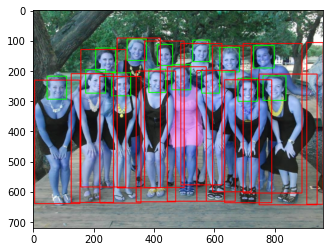

In [17]:
from matplotlib import pyplot
%matplotlib inline
pyplot.imshow(image_orig)

# The code below will not work so skip them

In [ ]:
# Define the model
model = make_yolov3_tiny_model()

In [ ]:
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)
        
        if conv['bnorm']: x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)    
        
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2: x = Activation('mish', name='mish_' + str(conv['layer_idx']))(x) 
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov3_tiny_model():
        
    input_image = Input(shape=(416, 416, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 16, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 0}])
    
    # Layer  1
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_1')(x)
    
    # Layer  2
    x = _conv_block(x, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 2}])
  
    # Layer  3
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_3')(x)
    
    # Layer  4
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 4}])   

    # Layer  5
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_5')(x)
    
    # Layer  6
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 6}])   
    
    # Layer  7
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_7')(x)
    
    # Layer  8
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 8}])   
    layer_8 = x
    
    # Layer  9
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_9')(x)
    
    # Layer  10
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 10}])
    layer_10 = x
    
    # Layer  11
    x = MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'max_11')(x)
    
    # Layer  12
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 12}])

    
    ###########
    
    # Layer  13
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 13}]) 
    layer_13 = x
        
    # Layer  14
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 14}])     
    
    # Layer  15
    x = _conv_block(x, [{'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 15}])    
    
    # Layer  16
    yolo_16 = x
    
    
    # Layer  17
    x = layer_13

    # Layer  18
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 18}])
   
    # Layer  19
    x = UpSampling2D(size=(2, 2), name = 'upsamp_19')(x)

    # Layer  20
    x = concatenate([layer_8, x],  name='concatenate_20')
    
    # Layer  21
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 21}])     
    
    # Layer  22
    x = _conv_block(x, [{'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 22}])    
    
    # Layer  23
    yolo_23 = x   
                                      
    model = Model(input_image, [yolo_16, yolo_23], name = 'Yolo_v3_tiny')    
    return model

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model( model, show_shapes=True)

In [ ]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(23):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [15, 22]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0


In [ ]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov3-tiny.weights')
weight_reader.load_weights(model)


In [ ]:
# save the model to file
#! rm models\yolo\yolov3-tiny.h5

model.save('models/yolo/yolov3-tiny_crowd.h5')
model.save('models/crowd')
! dir models\yolo\*.h5

In [ ]:
# Load the model
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov3-tiny_crowd.h5")

In [ ]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [ ]:
# Load the labels
labels = read_labels("models/yolo/crowd_classes.txt")
print(labels)
print("nb labels: ",len(labels))

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [ ]:
# Pre-process the image
input_w, input_h = 416, 416
photo_filename = 'images/0004.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

In [ ]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])

In [ ]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, nb_box, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)   
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [ ]:
# Compute the Yolo layers
obj_thresh = 0.5
anchors = [ [12, 16, 19, 36, 40, 28] ,  [36, 75, 76, 55, 72, 146], [142, 110, 192, 243, 459, 401] ]
scales_x_y = [1.05 , 1,1 , 1.2]
#anchors = [[81,82,  135,169,  344,319], [10,14,  23,27,  37,58]]
#scales_x_y = [1.0, 1.0]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, 3, scales_x_y[i])

print("nb boxes detected; ",len(boxes))

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.75)
print("nb boxes remaining; ",len(boxes))

In [ ]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [ ]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.5
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

In [ ]:
%matplotlib inline
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)